* TRABALHO FINAL: DESAFIO DE DADOS CT-MON
 - Alunos:
    - Arthur Sabino Santos
    - Luiz Nelson dos Santos Lima

In [29]:
# Instalação de pacotes (caso esteja em Notebook/Jupyter; não recomendado em scripts .py)
# !pip install gdown
!pip install --upgrade numpy pandas
!pip install --upgrade pandas

In [30]:
import zipfile
import gdown
from glob import glob
import os
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import linregress
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [31]:
# -------------------------------------------------------
# 1. Download e Extração dos Dados
# -------------------------------------------------------
file_id = '1JcR3KRQDwJyzqTbCiYF9IHRLYd0_8ITC'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'open-data.zip'
print("[INFO] Baixando os dados...")
gdown.download(url, output, quiet=False)

[INFO] Baixando os dados...


Downloading...
From (original): https://drive.google.com/uc?id=1JcR3KRQDwJyzqTbCiYF9IHRLYd0_8ITC
From (redirected): https://drive.google.com/uc?id=1JcR3KRQDwJyzqTbCiYF9IHRLYd0_8ITC&confirm=t&uuid=4683554b-4a76-412f-b9a9-7fdd25906772
To: d:\UFPI\Tópicos em Redes - Mineração de Dados\trab_final\final_task-project\notebooks\open-data.zip
100%|██████████| 42.1M/42.1M [00:01<00:00, 31.2MB/s]


'open-data.zip'

In [32]:
print("[INFO] Extraindo os arquivos...")
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('./')
print("[INFO] Dados extraídos com sucesso!")

[INFO] Extraindo os arquivos...
[INFO] Dados extraídos com sucesso!


In [33]:
# -------------------------------------------------------
# 2. Definição dos Caminhos e Inicialização
# -------------------------------------------------------
clientes_dash = glob("./Train/dash/*")
clientes_servidores = {'ba': 0, 'rj': 1, 'ce': 0, 'df': 1, 'es': 2, 'pi': 3}

X, y = [], []

In [34]:
# -------------------------------------------------------
# 3. Pré-processamento dos Dados
# -------------------------------------------------------
print("[INFO] Iniciando o pré-processamento dos dados...")
for cliente in clientes_dash:
    servidores = glob(os.path.join(cliente, '*'))
    for servidor in servidores:
        requisicoes = glob(os.path.join(servidor, '*'))
        dash_values = []
        for file_path in requisicoes:
            with open(file_path, 'r') as file:
                lines = file.readlines()
                for line in lines[:-1]:
                    try:
                        data = json.loads(line)
                        dash_values.append({
                            'timestamp': pd.to_datetime(data['timestamp'], unit='s'),
                            'rate': data['rate']
                        })
                    except (KeyError, ValueError):
                        continue

        if not dash_values:
            continue

        dash_serie = pd.DataFrame(dash_values).set_index("timestamp").sort_index()
        dash_serie_5min = dash_serie.resample('5min').agg({'rate': ['mean', 'std']}).dropna()
        dash_serie_5min.columns = ['rate_mean', 'rate_std']

        grouped = [
            dash_serie_5min.iloc[i:i + 12].copy()
            for i in range(0, dash_serie_5min.shape[0], 12)
            if i + 12 <= dash_serie_5min.shape[0]
        ]

        for group in grouped:
            group.reset_index(drop=True, inplace=True)

            if group.shape[0] < 12:
                continue

            features = [
                clientes_servidores[os.path.basename(cliente)],
                clientes_servidores[os.path.basename(servidor)],
                group['rate_mean'][:10].mean(),
                group['rate_std'][:10].std(),
                group['rate_mean'][9],
                group['rate_std'][9],
                group['rate_std'][:10].mean() / (group['rate_mean'][:10].mean() + 1e-5),
                group['rate_mean'][9] - group['rate_mean'][8] if group.shape[0] >= 10 else 0,
                linregress(range(10), group['rate_mean'][:10]).slope if len(group['rate_mean'][:10].unique()) > 1 else 0
            ]
            X.append(features)
            y.append([
                group['rate_mean'][10],
                group['rate_std'][10],
                group['rate_mean'][11],
                group['rate_std'][11]
            ])

[INFO] Iniciando o pré-processamento dos dados...


In [35]:
print("[INFO] Pré-processamento concluído.")
print(f"[INFO] Total de amostras geradas: {len(X)}")

[INFO] Pré-processamento concluído.
[INFO] Total de amostras geradas: 2657


In [36]:
# -------------------------------------------------------
# 4. Normalização e Preparação dos Dados
# -------------------------------------------------------
print("[INFO] Normalizando os dados...")
X_np = np.nan_to_num(np.array(X), nan=0.0, posinf=0.0, neginf=0.0)
y_np = np.nan_to_num(np.array(y), nan=0.0, posinf=0.0, neginf=0.0)

scaler = MinMaxScaler()
X_np_scaled = scaler.fit_transform(X_np)
print("[INFO] Normalização concluída.")

[INFO] Normalizando os dados...
[INFO] Normalização concluída.


In [37]:
# -------------------------------------------------------
# 5. Configuração e Treinamento do Modelo
# -------------------------------------------------------
print("[INFO] Configurando o modelo...")
rf_model = RandomForestRegressor(random_state=42)
multi_output_model = MultiOutputRegressor(
    RandomizedSearchCV(
        rf_model,
        param_distributions={
            'n_estimators': [300, 500, 800],
            'max_depth': [20, 30, None],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt'],
            'bootstrap': [True, False]
        },
        n_iter=50,
        cv=TimeSeriesSplit(n_splits=5),
        random_state=42,
        n_jobs=-1
    )
)

[INFO] Configurando o modelo...


In [38]:
print("[INFO] Treinando o modelo...")
multi_output_model.fit(X_np_scaled, y_np)
print("[INFO] Treinamento concluído.")

[INFO] Treinando o modelo...
[INFO] Treinamento concluído.


In [39]:
# Mostrar melhores parâmetros para cada saída
best_params = []
for i, estimator in enumerate(multi_output_model.estimators_):
    best_params.append(estimator.best_params_)
    print(f"Melhores parâmetros para a saída {i + 1}: {estimator.best_params_}")

Melhores parâmetros para a saída 1: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Melhores parâmetros para a saída 2: {'n_estimators': 800, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Melhores parâmetros para a saída 3: {'n_estimators': 800, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Melhores parâmetros para a saída 4: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [40]:
# Tabela de Melhores Hiperparâmetros
best_hyperparameters = pd.DataFrame(best_params)
best_hyperparameters.insert(0, "Output", ["Mean_1", "Stdev_1", "Mean_2", "Stdev_2"])
print("[INFO] Tabela de melhores hiperparâmetros gerada.")

[INFO] Tabela de melhores hiperparâmetros gerada.


In [41]:
# -------------------------------------------------------
# 6. Função para Calcular Métricas
# -------------------------------------------------------
def calculate_metrics(y_true, y_pred, label=""):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{label} Metrics:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MAPE: {mape:.4f}")
    return mse, mae, mape

In [43]:
# -------------------------------------------------------
# 7. Avaliação do Modelo e Baseline
# -------------------------------------------------------
print("[INFO] Avaliando o modelo no conjunto de treinamento...")
train_predictions = multi_output_model.predict(X_np_scaled)
train_predictions = np.nan_to_num(train_predictions, nan=0.0, posinf=0.0, neginf=0.0)

train_mse, train_mae, train_mape = calculate_metrics(y_np, train_predictions, label="Treinamento")

print("[INFO] Avaliando o baseline...")
baseline_mean = np.mean(y_np, axis=0)
baseline_predictions = np.tile(baseline_mean, (y_np.shape[0], 1))

baseline_train_mse, baseline_train_mae, baseline_train_mape = calculate_metrics(
    y_np, baseline_predictions, label="Baseline Treinamento")

[INFO] Avaliando o modelo no conjunto de treinamento...
Treinamento Metrics:
  MSE: 464192632.5997
  MAE: 11459.4305
  MAPE: 0.1462
[INFO] Avaliando o baseline...
Baseline Treinamento Metrics:
  MSE: 1435472914.4105
  MAE: 23453.6491
  MAPE: 0.2255


In [44]:
# -------------------------------------------------------
# 8. Submissão e Avaliação no Teste
# -------------------------------------------------------
print("[INFO] Gerando previsões para o conjunto de teste...")
Test_jsons = glob("./Test/*")
features = []
submission = []

for test in Test_jsons:
    with open(test, 'r') as file:
        data = json.load(file)
    rates_mean = [np.mean(dash['rate']) for dash in data['dash'] if 'rate' in dash]
    rates_std = [np.std(dash['rate']) for dash in data['dash'] if 'rate' in dash]

    if not rates_mean or not rates_std:
        rates_mean = [0] * 10
        rates_std = [0] * 10

    feat = [
        clientes_servidores[data['cliente']],
        clientes_servidores[data['servidor']],
        np.mean(rates_mean),
        np.std(rates_mean),
        rates_mean[-1],
        rates_std[-1],
        np.std(rates_std) / (np.mean(rates_mean) + 1e-5),
        rates_mean[-1] - rates_mean[-2] if len(rates_mean) > 1 else 0,
        linregress(range(len(rates_mean)), rates_mean).slope if len(rates_mean) > 1 else 0
    ]
    features.append(feat)

[INFO] Gerando previsões para o conjunto de teste...


In [45]:
features_np = np.array(features)
features_np_scaled = scaler.transform(features_np)

In [46]:
# Previsões
test_predictions = multi_output_model.predict(features_np_scaled)

In [47]:
# Calcular métricas
test_mse, test_mae, test_mape = calculate_metrics(y_np[-len(test_predictions):], test_predictions, label="Teste")

Teste Metrics:
  MSE: 1673557648.2981
  MAE: 26610.8768
  MAPE: 0.2725


In [48]:
# Comparação com baseline no conjunto de teste
baseline_test_predictions = np.tile(baseline_mean, (features_np_scaled.shape[0], 1))
baseline_test_mse, baseline_test_mae, baseline_test_mape = calculate_metrics(
    y_np[-len(test_predictions):], baseline_test_predictions, label="Baseline Teste"
)

Baseline Teste Metrics:
  MSE: 1424502412.4713
  MAE: 23946.2735
  MAPE: 0.2629


In [49]:
# Criar CSV
header = ["id", "mean_1", "stdev_1", "mean_2", "stdev_2"]
with open("submission.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for i, pred in enumerate(test_predictions):
        writer.writerow([os.path.splitext(os.path.basename(Test_jsons[i]))[0], *pred])

print("[INFO] Arquivo de submissão criado com sucesso!")

[INFO] Arquivo de submissão criado com sucesso!


In [50]:
# -------------------------------------------------------
# 9. Gerar Relatório de Métricas
# -------------------------------------------------------
metrics_data = {
    "Dataset": ["Treinamento", "Treinamento", "Teste", "Teste"],
    "Modelo": ["Random Forest", "Baseline", "Random Forest", "Baseline"],
    "MSE": [train_mse, baseline_train_mse, test_mse, baseline_test_mse],
    "MAE": [train_mae, baseline_train_mae, test_mae, baseline_test_mae],
    "MAPE": [train_mape, baseline_train_mape, test_mape, baseline_test_mape],
}

In [51]:
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv("metrics_report.csv", index=False, encoding="utf-8")

In [52]:
# -------------------------------------------------------
# 10. Visualização de Métricas
# -------------------------------------------------------
print("[INFO] Gerando tabelas e gráficos adicionais...")

[INFO] Gerando tabelas e gráficos adicionais...


In [53]:
# Tabela de Features Calculadas
features_calculated = pd.DataFrame({
    "Feature": [
        "rate_mean", "rate_std", "delta_mean", "slope_mean", "cliente_servidor"
    ],
    "Description": [
        "Média das taxas nos últimos 10 intervalos",
        "Desvio padrão das taxas nos últimos 10 intervalos",
        "Diferença entre as últimas duas médias",
        "Inclinação da regressão linear nos últimos 10 intervalos",
        "Cliente e servidor identificados numericamente"
    ],
    "Justification": [
        "Captura a tendência geral do desempenho",
        "Mede a variação na estabilidade",
        "Captura mudanças recentes",
        "Representa a tendência temporal",
        "Relaciona clientes e servidores às suas métricas"
    ]
})
features_calculated.to_csv("features_calculated.csv", index=False)


In [54]:
# Exportar tabela de melhores hiperparâmetros
best_hyperparameters.to_csv("best_hyperparameters.csv", index=False)

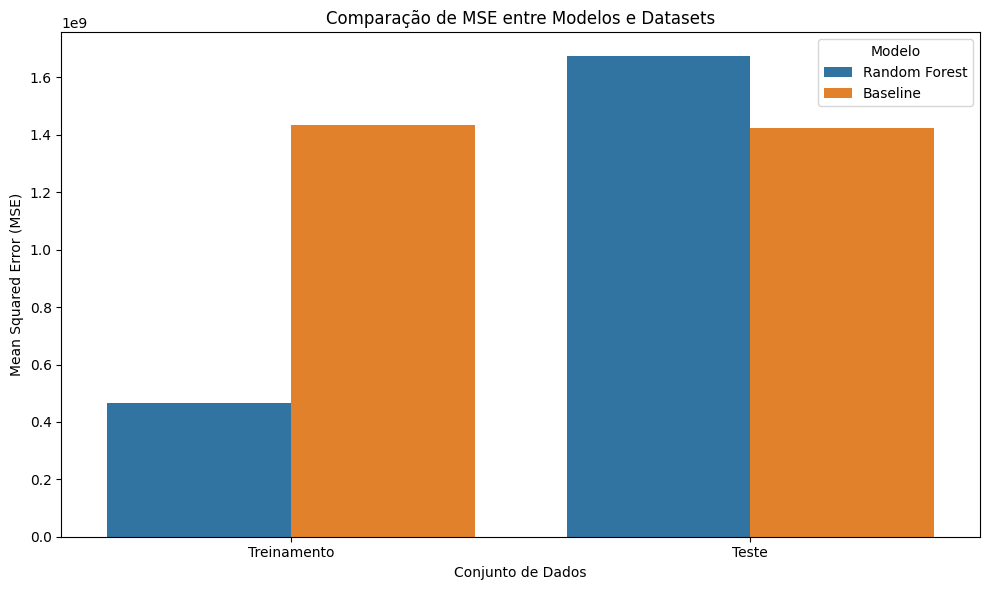

In [56]:

# Gráfico de comparação de MSE
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Dataset", y="MSE", hue="Modelo")
plt.title("Comparação de MSE entre Modelos e Datasets")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Conjunto de Dados")
plt.legend(title="Modelo")
plt.tight_layout()
plt.savefig("mse_comparison.png")
plt.show()

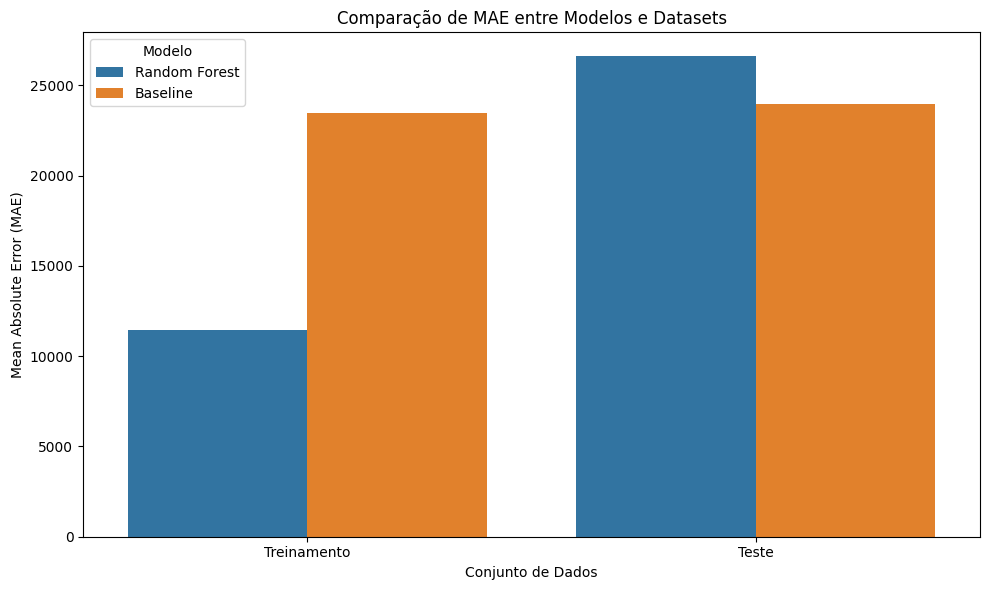

In [57]:
# Gráfico de comparação de MAE
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Dataset", y="MAE", hue="Modelo")
plt.title("Comparação de MAE entre Modelos e Datasets")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Conjunto de Dados")
plt.legend(title="Modelo")
plt.tight_layout()
plt.savefig("mae_comparison.png")
plt.show()

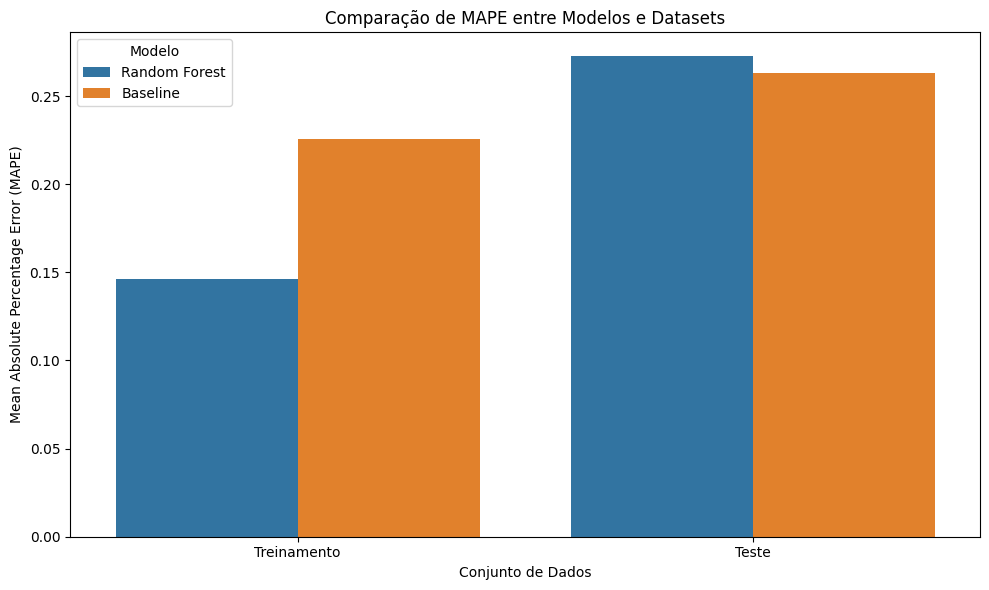

In [58]:
# Gráfico de comparação de MAPE
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x="Dataset", y="MAPE", hue="Modelo")
plt.title("Comparação de MAPE entre Modelos e Datasets")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.xlabel("Conjunto de Dados")
plt.legend(title="Modelo")
plt.tight_layout()
plt.savefig("mape_comparison.png")
plt.show()